<a href="https://colab.research.google.com/github/shizoda/education/blob/main/info_theory/communication_sender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 通信シミュレーション（送信側）

情報理論における符号化を学ぶため，雑音のある通信路を経由してメッセージを送信してみましょう．

## 準備

ストレージをマウントします．通信路として使用します．

In [ ]:
import os

try:
    from google.colab import drive
    IN_COLAB = True
    print("Running on Google Colab")
    drive.mount('/content/drive')
    saved_dir = '/content/drive/MyDrive/info-theory'
except ImportError:
    IN_COLAB = False
    print("Not running on Google Colab")
    saved_dir = '//nas/info-theory'

os.makedirs(saved_dir, exist_ok=True)
print(f"Saved directory is set to: {saved_dir}")

Running on Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved directory is set to: /content/drive/MyDrive/info-theory


## メッセージ

送り主，宛先，メッセージ本文を指定します．

なお，サンプルの英文は "e"，和文は「静」や「岡」が多用された文になっています．

In [ ]:
message_from = "alice"
message_to   = "bob"

message = "Everyone expects excellent experiences every evening. Each evening, Ellie eagerly eats exquisite edibles, enjoying every essence. Evenings envelop Ellie, embracing endless energy. Ellie engages effortlessly, expressing emotions endlessly. Every encounter elevates Ellie's enthusiasm, enriching every experience eternally."
# message = "静岡県は静かで美しい場所です。静岡市は県の中心です。静岡には静岡茶や静岡おでんなどの名物があります。静かな山々や岡の風景も楽しめます。"
print(f"メッセージ: {message}")

メッセージ: Everyone expects excellent experiences every evening. Each evening, Ellie eagerly eats exquisite edibles, enjoying every essence. Evenings envelop Ellie, embracing endless energy. Ellie engages effortlessly, expressing emotions endlessly. Every encounter elevates Ellie's enthusiasm, enriching every experience eternally.


## ハフマン符号の実装



In [ ]:
import heapq
from collections import Counter
import pandas as pd
import graphviz
from IPython.display import Image, display

class HuffmanNode:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(text):
    freq = Counter(text)
    heap = [HuffmanNode(char, freq) for char, freq in freq.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)

    return heap[0], freq

def build_codes(node, prefix="", codebook={}):
    if node is not None:
        if node.char is not None:
            codebook[node.char] = prefix
        build_codes(node.left, prefix + "0", codebook)
        build_codes(node.right, prefix + "1", codebook)
    return codebook

def plot_huffman_tree(node):
    dot = graphviz.Digraph()

    def add_nodes_edges(node, parent=None, edge_label=""):
        if node:
            if node.char:
                label = f"{node.char} ({node.freq})"
                color = "lightpink"
            else:
                label = str(node.freq)
                color = "lightblue"

            dot.node(str(id(node)), label=label, style="filled", fillcolor=color)

            if parent:
                dot.edge(str(id(parent)), str(id(node)), label=edge_label)
            add_nodes_edges(node.left, node, "0")
            add_nodes_edges(node.right, node, "1")

    add_nodes_edges(node)
    return dot

def huffman_encoding(text):
    root, freq_table = build_huffman_tree(text)

    # Create and display frequency table
    freq_df = pd.DataFrame(freq_table.items(), columns=['Character', 'Frequency'])
    display(freq_df)

    codebook = build_codes(root)

    # Create and display codebook table
    codebook_df = pd.DataFrame(codebook.items(), columns=['Character', 'Code'])
    display(codebook_df)

    encoded_text = ''.join(codebook[char] for char in text)
    encoded_text_breaks = ' '.join(codebook[char] for char in text)

    if len(encoded_text_breaks) >= 80:
        encoded_text_breaks = encoded_text_breaks[:80] + "..."

    print("\nHuffman Encoded: " + encoded_text_breaks)

    padding_length = (4 - len(encoded_text) % 4) % 4
    encoded_text += '0' * padding_length

    display_huffman_tree(plot_huffman_tree(root))

    return encoded_text, codebook, padding_length #, root

def huffman_decoding(encoded_text, codebook, padding_length):
    reverse_codebook = {v: k for k, v in codebook.items()}

    if padding_length > 0:
        encoded_text = encoded_text[:-padding_length]

    decoded_text = []
    current_code = ""

    for bit in encoded_text:
        current_code += bit
        if current_code in reverse_codebook:
            decoded_text.append(reverse_codebook[current_code])
            current_code = ""

    return ''.join(decoded_text)

def display_huffman_tree(dot):
    dot.render('huffman_tree', format='png', cleanup=True)
    display(Image(filename='huffman_tree.png'))

'''
def main():
    text = "this is an example for huffman encoding"
    encoded_text, codebook, padding_length, root = huffman_encoding(text)
    decoded_text = huffman_decoding(encoded_text, codebook, padding_length)

    print("\nEncoded Text:", encoded_text)
    print("Decoded Text:", decoded_text)

    dot = plot_huffman_tree(root)
    display_huffman_tree(dot)

if __name__ == "__main__":
    main()
'''

'\ndef main():\n    text = "this is an example for huffman encoding"\n    encoded_text, codebook, padding_length, root = huffman_encoding(text)\n    decoded_text = huffman_decoding(encoded_text, codebook, padding_length)\n    \n    print("\nEncoded Text:", encoded_text)\n    print("Decoded Text:", decoded_text)\n    \n    dot = plot_huffman_tree(root)\n    display_huffman_tree(dot)\n\nif __name__ == "__main__":\n    main()\n'

## ハミング符号の実装

In [ ]:
import numpy as np

color_dic = {"black":"\033[30m", "red":"\033[31m", "green":"\033[32m", "yellow":"\033[33m", "blue":"\033[34m", "end":"\033[0m"}

def print_color(text, color="red"):
    return color_dic[color] + text + color_dic["end"]

def format_binary_string(binary_string, chunk_size=7, max_length=50):
    if len(binary_string) > max_length:
        binary_string = binary_string[:max_length] + "..."
    formatted_string = ' '.join([binary_string[i:i+chunk_size] for i in range(0, len(binary_string), chunk_size)])
    return formatted_string

def hamming_encode(data):
    print(f"Hamming Input  : {format_binary_string(data, 4)}")

    def calculate_parity_bits(bits):
        p1 = bits[0] ^ bits[1] ^ bits[3]
        p2 = bits[0] ^ bits[2] ^ bits[3]
        p3 = bits[1] ^ bits[2] ^ bits[3]
        return [p1, p2, p3]

    encoded_data = []
    for i in range(0, len(data), 4):
        block = [int(bit) for bit in data[i:i+4]]
        if len(block) < 4:
            block.extend([0] * (4 - len(block)))  # Padding with zeros if less than 4 bits
        parity_bits = calculate_parity_bits(block)
        encoded_block = [parity_bits[0], parity_bits[1], block[0], parity_bits[2], block[1], block[2], block[3]]
        encoded_data.extend(encoded_block)

    encoded_str = ''.join(map(str, encoded_data))
    formatted_encoded_str = format_binary_string(encoded_str, 7)
    formatted_encoded_str = ''.join([print_color(bit, 'blue') if i % 8 in [0, 1, 3] else bit for i, bit in enumerate(formatted_encoded_str)])#.replace(" ", ""))])

    print(f"Hamming Encoded: {formatted_encoded_str}")
    return encoded_str

def hamming_decode(data):
    def calculate_error_syndrome(bits):
        p1 = bits[0] ^ bits[2] ^ bits[4] ^ bits[6]
        p2 = bits[1] ^ bits[2] ^ bits[5] ^ bits[6]
        p3 = bits[3] ^ bits[4] ^ bits[5] ^ bits[6]
        return p1, p2, p3

    decoded_data = []
    decoded_data_all = []
    n_corrected = 0
    corrected_blocks = []

    for i in range(0, len(data), 7):
        block = [int(bit) for bit in data[i:i+7]]
        p1, p2, p3 = calculate_error_syndrome(block)
        error_position = p1 + (p2 << 1) + (p3 << 2)
        original_block = ''.join(map(str, block))
        if error_position:
            block[error_position - 1] ^= 1  # Correct the error
            corrected = ''.join(map(str, block))
            if n_corrected < 10:
                corrected_blocks.append((i, error_position, original_block, corrected))
            n_corrected += 1

        decoded_block = [block[2], block[4], block[5], block[6]]
        decoded_data.extend(decoded_block)
        decoded_data_all.extend(block)

    decoded_str = ''.join(map(str, decoded_data))
    decoded_str_all = ''.join(map(str, decoded_data_all))

    # Print the corrected blocks
    print(f"{n_corrected} corrections in total.")
    for i, error_position, original, corrected in corrected_blocks:
        print(f"  (Block-{i//7}, Bit-{error_position-1}): {format_binary_string(original)} --> {format_binary_string(corrected)}")
    if n_corrected > 10:
        print("      etc.")

    formatted_data = format_binary_string(data, 7)
    formatted_data = ''.join([print_color(bit, 'blue') if i % 8 in [0, 1, 3] else bit for i, bit in enumerate(formatted_data)])
    formatted_decoded_str_all = format_binary_string(decoded_str_all, 7)
    formatted_decoded_str_all = ''.join([print_color(bit, 'blue') if i % 7 in [0, 1, 3] else bit for i, bit in enumerate(formatted_decoded_str_all.replace(" ", ""))])
    formatted_decoded_str = format_binary_string(decoded_str, 4)

    print("Received       :", formatted_data)
    print("Hamming Decoded:", formatted_decoded_str_all)
    print("Hamming Output :", formatted_decoded_str)
    return decoded_str

    '''
    # Example usage:
    data = "1101001100110101"
    encoded_data = hamming_encode(data)
    decoded_data = hamming_decode(encoded_data)
    '''

In [ ]:
import random, json

def print_color(text, color="red"):
    return color_dic[color] + text + color_dic["end"]

def format_binary_string(binary_string, chunk_size=7, max_length=50):
    if len(binary_string) > max_length:
        binary_string = binary_string[:max_length] + "..."
    formatted_string = ' '.join([binary_string[i:i+chunk_size] for i in range(0, len(binary_string), chunk_size)])
    return formatted_string

def introduce_errors(encoded_data, error_rate):
    result = []
    flip_prohibited_count = 0  # 反転禁止カウンター
    error_indices = []

    for i, bit in enumerate(encoded_data):
        if flip_prohibited_count > 0:
            result.append(bit)
            flip_prohibited_count -= 1
        else:
            if random.random() < error_rate:
                flipped_bit = '1' if bit == '0' else '0'
                result.append(flipped_bit)
                error_indices.append(i)
                flip_prohibited_count = 6  # 反転後、次の6ビットは反転禁止
            else:
                result.append(bit)

    introduced_errors_data = ''.join(result)

    # 空白を含む形式にフォーマット
    encoded_data_spaced = format_binary_string(encoded_data, 7)
    introduced_errors_data_spaced = format_binary_string(introduced_errors_data, 7)

    # 色付けされた文字列を作成
    trans_data_colored = ''.join([
        print_color(bit, 'red') if encoded_data_spaced[i] != introduced_errors_data_spaced[i] else bit
        for i, bit in enumerate(introduced_errors_data_spaced)
    ])

    print()
    print("雑音のある通信路")
    print(f"Transmitted    : {trans_data_colored}")
    return introduced_errors_data



 △△△符号化器：ハフマン符号


,Character,Frequency
0,E,8
1,v,10
2,e,67
3,r,15
4,y,11
5,o,7
6,n,27
7,,36
8,x,6
9,p,5


,Character,Code
0,e,00
1,E,01000
2,a,01001
3,i,0101
4,,011
5,c,10000
6,p,100010
7,",",100011
8,v,10010
9,t,10011



Huffman Encoded: 01000 10010 00 11111 11000 111100 1110 00 011 00 110111 100010 00 10000 10011 10...


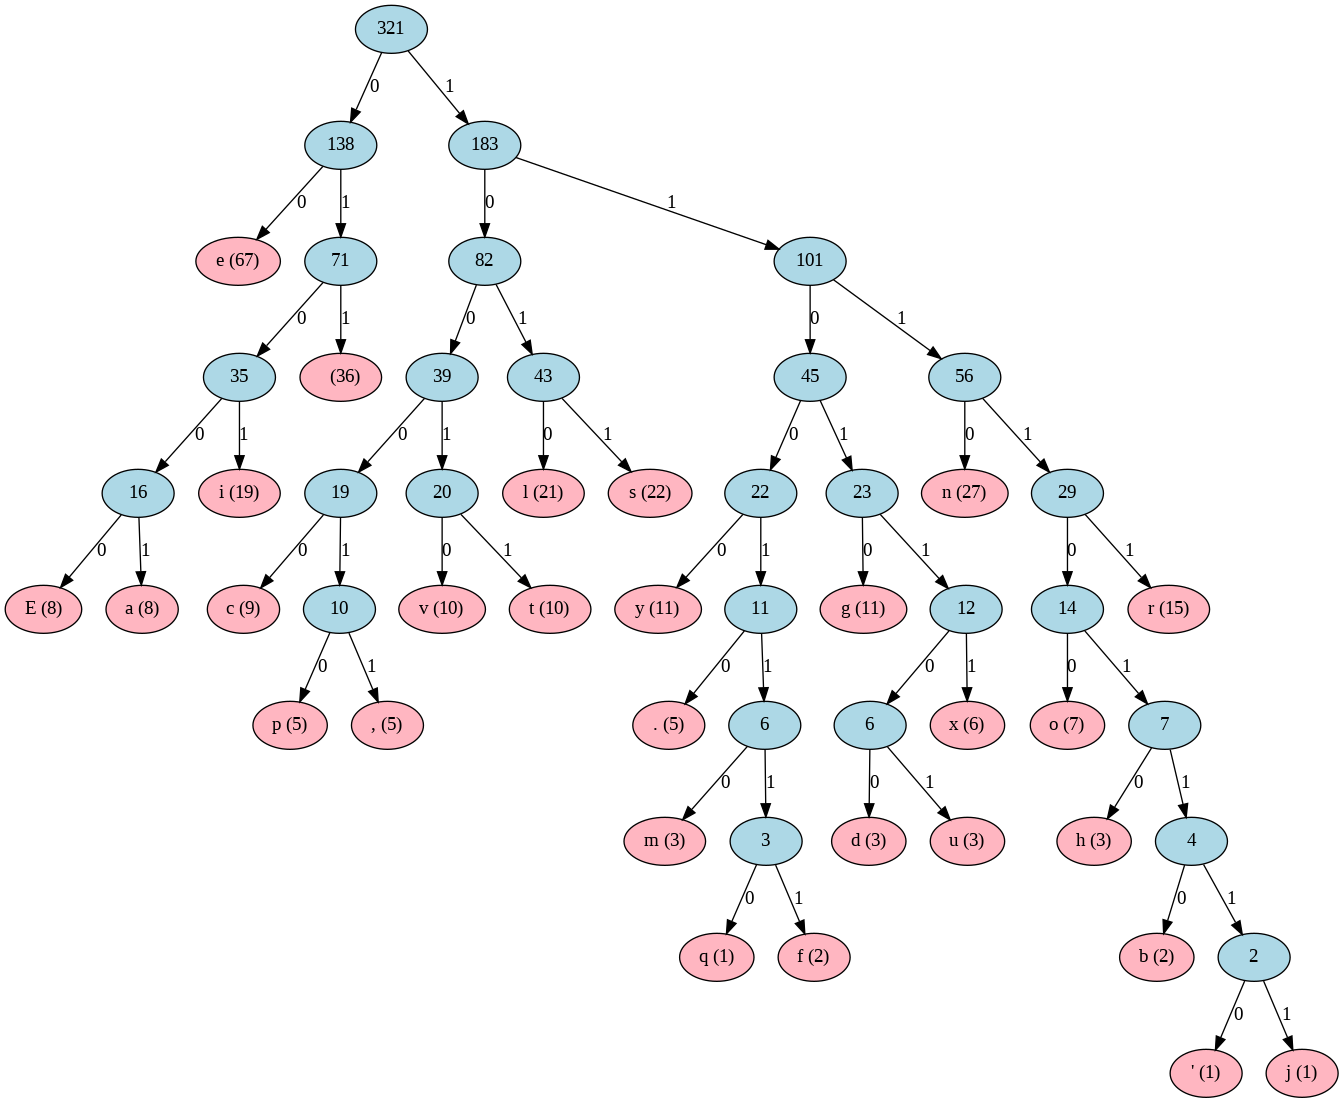


 通信路符号化器：ハミング符号
Hamming Input  : 0100 0100 1000 1111 1110 0011 1100 1110 0001 1001 1011 1100 01.. .
Hamming Encoded: 1001100 1001100 1110000 1111111 0010110 1000011 0111100 0...

 雑音のある通信路から送信

雑音のある通信路
Transmitted    : 1011100 1000100 1111000 1111101 0010110 0000011 0110100 0...


In [ ]:
# 送信側
def send_message(saved_dir, orig, other, message, error_rate=0.05):
    # ファイル名設定
    data_filename = f"{saved_dir}/{orig}-{other}.txt"
    codebook_filename = f"{saved_dir}/{orig}-{other}-codebook.json"
    padding_filename = f"{saved_dir}/{orig}-{other}-padding.txt"

    # 正しく並べ替えてください
    #### ここから

    print("\n △△△符号化器：ハフマン符号")
    encoded_text, codebook, padding_length = huffman_encoding(message)

    print("\n 通信路符号化器：ハミング符号")
    encoded_data = hamming_encode(encoded_text)

    print("\n 雑音のある通信路から送信")
    transmitted_data = introduce_errors(encoded_data, error_rate)

    #### ここまで

    # 相手に届くビットには雑音が載る（一部の 0 / 1 がひっくり返る）

    save_to_file(data_filename, transmitted_data)
    save_codebook(codebook_filename, codebook)
    save_padding_length(padding_filename, padding_length)

send_message(saved_dir, message_from, message_to, message, error_rate=0.2)